# Correspondence Autoencoder Sequence-to-Sequence Model for Speech Incorporating Speaker Information

Herman Kamper, Stellenbosch University, 2018.

## Preamble

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

In [2]:
sys.path.append(path.join("..", "src"))
sys.path.append(path.join("..", "embeddings"))

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE
import batching
import plotting
import samediff
import tflego
import training

output_dir = "/tmp/data-kamperh/"

## Data

In [3]:
# Training data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart1",
    "devpart1_utd_terms.mfcc.cmvn_dd.npz")
    )

# Data and labels
train_x = []
train_labels = []
train_speakers = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    speaker = utt_key.split("_")[1][:3]
    train_labels.append(word)
    train_speakers.append(speaker)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 12021
E.g. item shape: (62, 39)


In [4]:
# Convert training speakers to integers
train_speaker_set = set(train_speakers)
speaker_to_id = {}
id_to_speaker = {}
for i, speaker in enumerate(sorted(list(train_speaker_set))):
    speaker_to_id[speaker] = i
    id_to_speaker[i] = speaker
train_speaker_id = []
for speaker in train_speakers:
    train_speaker_id.append(speaker_to_id[speaker])
train_speaker_id = np.array(train_speaker_id, dtype=NP_ITYPE)

speaker_gender_dict = {
    "s01": "f", "s02": "f", "s03": "m", "s04": "f", "s05": "f", "s06": "m",
    "s07": "f", "s08": "f", "s09": "f", "s10": "m", "s11": "m", "s12": "f",
    "s13": "m", "s14": "f", "s15": "m", "s16": "f", "s17": "f", "s18": "f",
    "s19": "m", "s20": "f", "s21": "f", "s22": "m", "s23": "m", "s24": "m",
    "s25": "f", "s26": "f", "s27": "f", "s28": "m", "s29": "m", "s30": "m",
    "s31": "f", "s32": "m", "s33": "m", "s34": "m", "s35": "m", "s36": "m",
    "s37": "f", "s38": "m", "s39": "f", "s40": "m"
    }

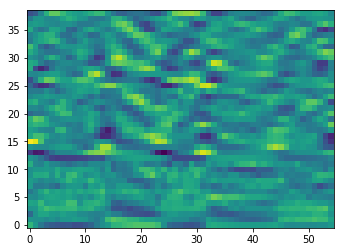

In [5]:
plt.imshow(train_x[3277].T, origin="bottom");

In [6]:
# Development data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart2",
    "devpart2.samediff.mfcc.cmvn_dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    val_labels.append(word)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2733
E.g. item shape: (61, 39)


In [7]:
# Truncate and limit dimensionality
max_length = 100
d_frame = 13  # None
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

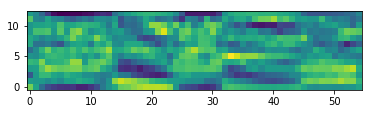

In [8]:
plt.imshow(train_x[3277].T, origin="bottom");

## Autoencoder pretraining

In [9]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 100  # 100
n_val_interval = 1
batch_size = 300
n_buckets = 3
pair_list = batching.get_pair_list(train_labels)

# Model parameters
n_input = d_frame
enc_n_hiddens = [400, 400, 400]
dec_n_hiddens = [400, 400, 400]
build_latent_func = tflego.build_autoencoder
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "n_z": 130, # 130,
    "dec_n_hiddens": [dec_n_hiddens[0]],
    "activation": tf.nn.relu
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
pretrain_intermediate_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.pretrain.tmp.ckpt")
pretrain_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.pretrain.ckpt")
intermediate_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.tmp.ckpt")
model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae.ckpt")

# Model
a = tf.placeholder(TF_DTYPE, [None, None, n_input])
a_lengths = tf.placeholder(TF_ITYPE, [None])
b = tf.placeholder(TF_DTYPE, [None, None, n_input])
b_lengths = tf.placeholder(TF_ITYPE, [None])
network_dict = tflego.build_multi_encdec_lazydynamic_latentfunc(
    a, a_lengths, enc_n_hiddens, dec_n_hiddens, build_latent_func,
    latent_func_kwargs, y_lengths=b_lengths, rnn_type=rnn_type
    )
encoder_states = network_dict["encoder_states"]
ae = network_dict["latent_layer"]
z = ae["z"]
y = network_dict["decoder_output"]
mask = network_dict["mask"]

y *= tf.expand_dims(mask, -1)  # safety

# Reconstruction loss
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(b - y), -1), -1) /
    tf.reduce_sum(mask, 1)
    )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [10]:
def samediff_val():
    # Embed validation
    np.random.seed(1)
    val_batch_iterator = batching.SimpleIterator(
        val_x, len(val_x), False
        )
    labels = [val_labels[i] for i in val_batch_iterator.indices]
    saver = tf.train.Saver()
    with tf.Session() as session:
        saver.restore(session, val_model_fn)
        for batch_x_padded, batch_x_lengths in val_batch_iterator:
            np_x = batch_x_padded
            np_x_lengths = batch_x_lengths
            np_z = session.run(
                [z], feed_dict={a: np_x, a_lengths: np_x_lengths}
                )[0]
            break  # single batch

    embed_dict = {}
    for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
        embed_dict[utt_key] = np_z[i]

#     np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
#     distances = pdist(np_z_normalised, metric="cosine")
#     matches = samediff.generate_matches_array(labels)
#     ap, prb = samediff.average_precision(
#         distances[matches == True], distances[matches == False]
#         )
        
    # Same-different
    distances = pdist(np_z, metric="cosine")
    matches = samediff.generate_matches_array(labels)
    ap, prb = samediff.average_precision(
        distances[matches == True], distances[matches == False]
        )    
    return [prb, -ap]

In [11]:
# Autoencoder pretraining
np.random.seed(1)

train_batch_iterator = batching.PairedBucketIterator(
    train_x, [(i, i) for i in xrange(len(train_x))], batch_size, n_buckets, True
    )

val_model_fn = pretrain_intermediate_model_fn
record_dict = training.train_fixed_epochs_external_val(
    n_epochs, optimizer, loss, train_batch_iterator,
    [a, a_lengths, b, b_lengths], samediff_val, save_model_fn=pretrain_intermediate_model_fn, save_best_val_model_fn=pretrain_model_fn,
    n_val_interval=n_val_interval
    )

2018-12-05 09:53:48.862918
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.836 sec, train loss: 1.0174129, val loss: [0.042772481319247616, -0.01279507996900277] *
Epoch 1:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.092 sec, train loss: 0.8164126, val loss: [0.06518938417933522, -0.02342760935767514] *
Epoch 2:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
14.749 sec, train loss: 0.7676047, val loss: [0.10225371777422607, -0.047693945922034846] *
Epoch 3:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
14.886 sec, train loss: 0.7224067, val loss: [0.1265137851069312, -0.06764436245873313] *
Epoch 4:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
14.783 sec, train loss: 0.69

15.858 sec, train loss: 0.26377955, val loss: [0.2842606760499042, -0.2314344037455499]
Epoch 40:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.929 sec, train loss: 0.25685412, val loss: [0.287775349358511, -0.23362220795992483]
Epoch 41:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
16.079 sec, train loss: 0.26313692, val loss: [0.2850345970714462, -0.23511262931761737] *
Epoch 42:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.848 sec, train loss: 0.26139084, val loss: [0.2872970883792837, -0.23322969229265628]
Epoch 43:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
15.948 sec, train loss: 0.24925399, val loss: [0.290904406080907, -0.23749313809040706] *
Epoch 44:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynami

16.837 sec, train loss: 0.19437143, val loss: [0.28343210512754446, -0.2379317213724174]
Epoch 80:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
16.898 sec, train loss: 0.19872272, val loss: [0.28807008502963155, -0.23993948432391418]
Epoch 81:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
17.046 sec, train loss: 0.19605015, val loss: [0.2847204328781242, -0.23849579377673072]
Epoch 82:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
16.912 sec, train loss: 0.19026361, val loss: [0.2896160783303272, -0.24113692210929624]
Epoch 83:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.tmp.ckpt
17.124 sec, train loss: 0.1909695, val loss: [0.2823650697376259, -0.23789964343852898]
Epoch 84:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic

In [12]:
# Embed validation
val_batch_iterator = batching.SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, pretrain_model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z], feed_dict={a: np_x, a_lengths: np_x_lengths}
            )[0]
        np_y = session.run(
            [y], feed_dict={a: np_x, a_lengths: np_x_lengths, b_lengths: np_x_lengths}
            )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.ckpt


In [13]:
# Same-different evaluation
distances = pdist(np_z, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.2424
Precision-recall breakeven: 0.2909


## CAE training

In [14]:
# Training parameters
learning_rate = 0.001
n_epochs = 10 # 100
n_val_interval = 1
batch_size = 300
n_buckets = 3
pair_list = batching.get_pair_list(train_labels)

In [15]:
# Train correspondence autoencoder
train_batch_iterator = batching.PairedBucketIterator(
    train_x, pair_list, batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=True
    )
val_model_fn = intermediate_model_fn
record_dict = training.train_fixed_epochs_external_val(
    n_epochs, optimizer, loss, train_batch_iterator,
    [a, a_lengths, b, b_lengths], samediff_val, save_model_fn=intermediate_model_fn, save_best_val_model_fn=model_fn,
    n_val_interval=n_val_interval, load_model_fn=pretrain_model_fn
    )

2018-12-05 10:21:15.949343
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.pretrain.ckpt
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.tmp.ckpt
33.917 sec, train loss: 0.81916666, val loss: [0.33702653955166195, -0.2938603112946632] *
Epoch 1:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.tmp.ckpt
32.812 sec, train loss: 0.77281153, val loss: [0.3393845506494485, -0.295559355619533] *
Epoch 2:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.tmp.ckpt
32.840 sec, train loss: 0.75694215, val loss: [0.33960319505282144, -0.2989904242610953] *
Epoch 3:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.tmp.ckpt
33.126 sec, train loss: 0.74960685, val loss: [0.33960319505282144, -0.29478494032134733]
Epoch 4:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydy

In [16]:
# Embed validation
val_batch_iterator = batching.SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z], feed_dict={a: np_x, a_lengths: np_x_lengths}
            )[0]
        np_y = session.run(
            [y], feed_dict={a: np_x, a_lengths: np_x_lengths, b_lengths: np_x_lengths}
            )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae.ckpt


In [17]:
# Same-different evaluation
distances = pdist(np_z, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.2990
Precision-recall breakeven: 0.3396


In [18]:
# Same-different evaluation after normalisation
np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
distances = pdist(np_z_normalised, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.3200
Precision-recall breakeven: 0.3607


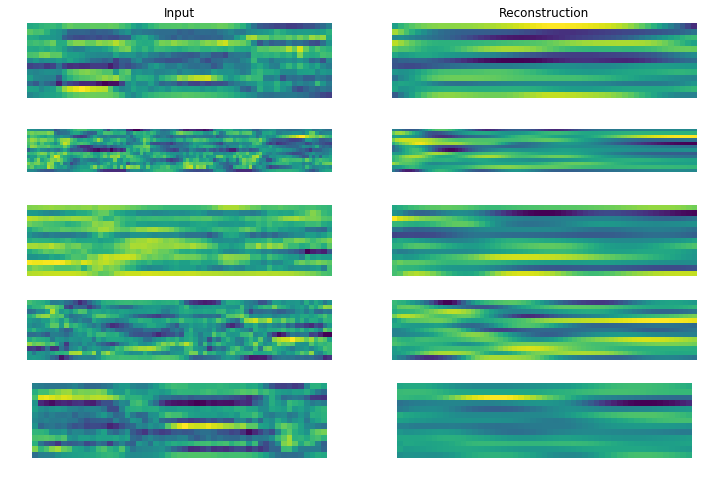

In [19]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

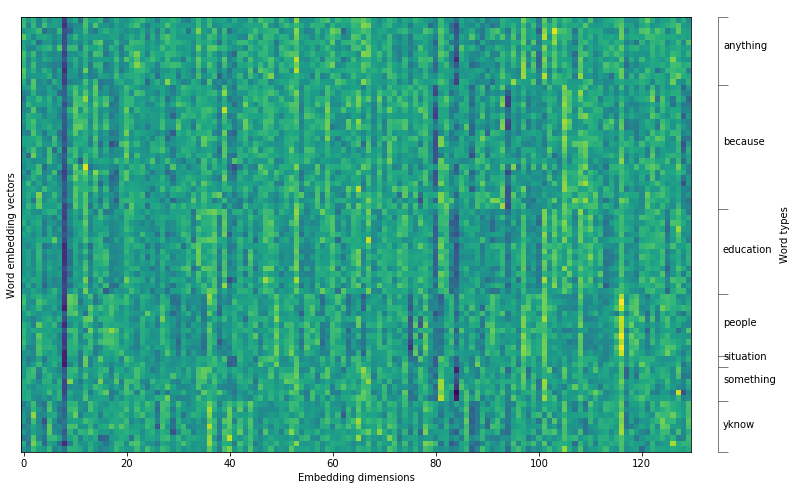

In [20]:
plotting.plot_raw_embeds(
    embed_dict, ["because", "yknow", "people", "something", "anything", "education", "situation"],
    mvn=False, figsize=(12, 8)
    )

## Autoencoder pretraining with speaker information

In [21]:
from tflego import build_linear, build_multi_rnn

def build_multi_encdec_lazydynamic_latentfunc_dev(x, x_lengths, enc_n_hiddens,
        dec_n_hiddens, build_latent_func, latent_func_kwargs, rnn_type="lstm",
        keep_prob=1., y_lengths=None, bidirectional=False,
        add_conditioning_tensor=None, **kwargs):
    """
    Multi-layer encoder-decoder with conditioning and a generic latent layer.

    The function name refers to the simple implementation essentially using
    `tf.nn.dynamic_rnn` for both the encoder and decoder. Since the encoding
    state is used as input at each decoding time step, the output of the
    decoder is never used. As in `build_encdec_outback`, a linear
    transformation is applied to the output of the decoder such that the final
    output dimensionality matches that of the input `x`. A generic latent layer
    is built according to the `build_latent_func` and `latent_func_kwargs`
    parameters.

    Parameters
    ----------
    x : Tensor [n_data, maxlength, d_in]
    build_latent_func : function
        The function to build the latent layer. The function's first parameter
        should be the input Tensor, and it should return a dictionary with an
        element "y" giving the output.
    latent_func_kargs : dict
        Arguments to pass on to `build_latent_func`.
    add_conditioning_tensor : Tensor [n_data, d_embedding]
        If provided, each time step of the decoder is conditioned on the 
        concatenation of the latent representation and this tensor.
    """

    maxlength = (
        tf.reduce_max(x_lengths) if y_lengths is None else
        tf.reduce_max([tf.reduce_max(x_lengths), tf.reduce_max(y_lengths)])
        )
    n_output = x.get_shape().as_list()[-1]

    # Encoder
    if bidirectional:
        encoder_output, encoder_states = build_bidirectional_multi_rnn(
            x, x_lengths, enc_n_hiddens, rnn_type, keep_prob,
            scope="rnn_encoder", **kwargs
            )
    else:
        encoder_output, encoder_states = build_multi_rnn(
            x, x_lengths, enc_n_hiddens, rnn_type, keep_prob,
            scope="rnn_encoder", **kwargs
            )

    # Latent layer
    if rnn_type == "lstm":
        c, h = encoder_states
    elif rnn_type == "gru" or rnn_type == "rnn":
        c = encoder_states
    latent_layer = build_latent_func(c, **latent_func_kwargs)
    
    # Add additional conditioning if provided
    if add_conditioning_tensor is not None:
        x = tf.concat([latent_layer["y"], add_conditioning_tensor], axis=1)
    else:
        x = latent_layer["y"]
#     print(x.shape)

    # Decoder

    # Repeat encoder states
    decoder_input = tf.reshape(
        tf.tile(x, [1, maxlength]), [-1, maxlength, dec_n_hiddens[0]]
        )

    # Decoding RNN
    if bidirectional:
        decoder_output, decoder_states = build_bidirectional_multi_rnn(
            decoder_input, x_lengths if y_lengths is None else y_lengths,
            dec_n_hiddens, rnn_type, keep_prob, scope="rnn_decoder", **kwargs
            )
    else:
        decoder_output, decoder_states = build_multi_rnn(
            decoder_input, x_lengths if y_lengths is None else y_lengths,
            dec_n_hiddens, rnn_type, keep_prob, scope="rnn_decoder", **kwargs
            )
    mask = tf.sign(tf.reduce_max(tf.abs(decoder_output), 2))

    # Final linear layer
    with tf.variable_scope("rnn_decoder/linear_output"):
        decoder_output = tf.reshape(
            decoder_output, [-1, int(dec_n_hiddens[-1] * 2) if bidirectional
            else dec_n_hiddens[-1]]
            )
        decoder_output = build_linear(decoder_output, n_output)
        decoder_output = tf.reshape(decoder_output, [-1, maxlength, n_output])
        decoder_output *= tf.expand_dims(mask, -1)

    return {
        "encoder_states": encoder_states, "latent_layer": latent_layer, 
        "decoder_output": decoder_output, "mask": mask
        }

In [22]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 100  # 100
n_val_interval = 1
batch_size = 300
n_buckets = 3
pair_list = batching.get_pair_list(train_labels)

# Model parameters
n_input = d_frame
n_speakers = max(speaker_to_id.values()) + 1
d_speaker_embedding = 50
enc_n_hiddens = [400, 400, 400]
dec_n_hiddens = [400 + d_speaker_embedding, 400, 400]
build_latent_func = tflego.build_autoencoder
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "n_z": 130, # 130,
    "dec_n_hiddens": [dec_n_hiddens[0] - d_speaker_embedding],
    "activation": tf.nn.relu
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
pretrain_intermediate_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt")
pretrain_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae_speaker.pretrain.ckpt")
intermediate_model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae_speaker.tmp.ckpt")
model_fn = path.join(output_dir, "multi_lazydynamic_latent_cae_speaker.ckpt")

# Model

a = tf.placeholder(TF_DTYPE, [None, None, n_input])
a_lengths = tf.placeholder(TF_ITYPE, [None])
b = tf.placeholder(TF_DTYPE, [None, None, n_input])
b_lengths = tf.placeholder(TF_ITYPE, [None])
speaker_id = tf.placeholder(TF_ITYPE, [None])

with tf.variable_scope("speaker_embedding"):
    speaker_embedding = tf.get_variable(
            "E", [n_speakers, d_speaker_embedding], dtype=TF_DTYPE,
            initializer=tf.contrib.layers.xavier_initializer()
            )
    embedding_lookup = tf.nn.embedding_lookup(speaker_embedding, speaker_id)

network_dict = build_multi_encdec_lazydynamic_latentfunc_dev(
    a, a_lengths, enc_n_hiddens, dec_n_hiddens, build_latent_func,
    latent_func_kwargs, y_lengths=b_lengths, rnn_type=rnn_type,
    add_conditioning_tensor=embedding_lookup
    )
encoder_states = network_dict["encoder_states"]
ae = network_dict["latent_layer"]
z = ae["z"]
y = network_dict["decoder_output"]
mask = network_dict["mask"]

y *= tf.expand_dims(mask, -1)  # safety

# Reconstruction loss
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(b - y), -1), -1) /
    tf.reduce_sum(mask, 1)
    )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [23]:
class PairedBucketSpeakerIterator(object):
    """Iterator over bucketed pairs of sequences with speaker information."""
    
    def __init__(self, x_list, speaker_ids, pair_list, batch_size, n_buckets,
            shuffle_every_epoch=False):
        
        # Attributes
        self.x_list = x_list
        self.speaker_ids = speaker_ids
        self.pair_list = pair_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        # self.n_batches = int(len(self.x_lengths)/batch_size)
        self.n_batches = int(len(self.pair_list)/self.batch_size)
        
        # Set up bucketing
        self.n_buckets = n_buckets
        sorted_indices = np.argsort(
            [max(len(x_list[i]), len(x_list[j])) for i, j in pair_list]
            )
        # bucket_size = int(len(self.x_lengths)/self.n_buckets)
        bucket_size = int(len(self.pair_list)/self.n_buckets)
        self.buckets = []
        for i_bucket in xrange(n_buckets):
            self.buckets.append(
                sorted_indices[i_bucket*bucket_size:(i_bucket + 1)*bucket_size]
                )
        self.shuffle()

    def shuffle(self):
        for i_bucket in xrange(self.n_buckets):
            np.random.shuffle(self.buckets[i_bucket])
        self.indices = np.concatenate(self.buckets)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            self.shuffle()
        
        for i_batch in xrange(self.n_batches):
            
            batch_pair_list = [
                self.pair_list[i] for i in self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size]
                ]

            batch_indices_a = [i for i, j in batch_pair_list]
            batch_indices_b = [j for i, j in batch_pair_list]
            
            batch_lengths_a = self.x_lengths[batch_indices_a]
            batch_lengths_b = self.x_lengths[batch_indices_b]
                 
            batch_speaker_a = self.speaker_ids[batch_indices_a]
            batch_speaker_b = self.speaker_ids[batch_indices_b]
            
            n_pad = max(np.max(batch_lengths_a), np.max(batch_lengths_b))
            
            # Pad to maximum length in batch            
            batch_padded_a = np.zeros(
                (len(batch_indices_a), n_pad, self.n_input), dtype=NP_DTYPE
                )
            batch_padded_b = np.zeros(
                (len(batch_indices_b), n_pad, self.n_input), dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_lengths_a):
                seq = self.x_list[batch_indices_a[i]]
                batch_padded_a[i, :length, :] = seq
            for i, length in enumerate(batch_lengths_b):
                seq = self.x_list[batch_indices_b[i]]
                batch_padded_b[i, :length, :] = seq
            
#             print(
#                 batch_padded_a, batch_lengths_a, batch_padded_b,
#                 batch_lengths_b, batch_speaker_b            
#                 )
#             print(
#                 batch_padded_a.shape, batch_lengths_a.shape, batch_padded_b.shape,
#                 batch_lengths_b.shape, batch_speaker_b.shape            
#                 )
            yield (
                batch_padded_a, batch_lengths_a, batch_padded_b,
                batch_lengths_b, batch_speaker_b
                )

In [24]:
# Autoencoder pretraining
np.random.seed(1)

train_batch_iterator = PairedBucketSpeakerIterator(
    train_x, train_speaker_id, [(i, i) for i in xrange(len(train_x))], batch_size, n_buckets, True
    )

val_model_fn = pretrain_intermediate_model_fn
record_dict = training.train_fixed_epochs_external_val(
    n_epochs, optimizer, loss, train_batch_iterator,
    [a, a_lengths, b, b_lengths, speaker_id], samediff_val, save_model_fn=pretrain_intermediate_model_fn, save_best_val_model_fn=pretrain_model_fn,
    n_val_interval=n_val_interval
    )

2018-12-05 10:27:12.154884
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt
16.842 sec, train loss: 1.0939133, val loss: [0.023189899510435454, -0.006594919586693293] *
Epoch 1:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt
15.434 sec, train loss: 0.8612, val loss: [0.05230610667353775, -0.014999305296624247] *
Epoch 2:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt
15.668 sec, train loss: 0.8026823, val loss: [0.07939771836824183, -0.03015514188452815] *
Epoch 3:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt
15.382 sec, train loss: 0.7486913, val loss: [0.10718886884823499, -0.054083526185743] *
Epoch 4:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt
16.300 sec, train loss: 0.28089008, val loss: [0.29730774678578487, -0.24470150917350014]
Epoch 39:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt
16.353 sec, train loss: 0.26925308, val loss: [0.29327664779707235, -0.24243304516581143]
Epoch 40:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt
16.324 sec, train loss: 0.2741757, val loss: [0.2981710324598208, -0.2478795594749149] *
Epoch 41:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt
16.105 sec, train loss: 0.27159616, val loss: [0.2913822024391011, -0.24182282115777526]
Epoch 42:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt
16.707 sec, train loss: 0.2

17.542 sec, train loss: 0.19063517, val loss: [0.2983269495572479, -0.2511628170987151]
Epoch 77:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt
17.209 sec, train loss: 0.19641845, val loss: [0.2983767070342695, -0.2509065456180569]
Epoch 78:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt
17.195 sec, train loss: 0.19960973, val loss: [0.29502705488276215, -0.24938857103721931]
Epoch 79:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt
17.233 sec, train loss: 0.19304189, val loss: [0.3001803658850812, -0.25313236731236316]
Epoch 80:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.tmp.ckpt
17.622 sec, train loss: 0.19722272, val loss: [0.30121102808554495, -0.25168188682435116]
Epoch 81:
INFO:tensorflow:Restoring parameters from /tm

In [25]:
# Code from https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage

def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))

    
def compute_serial_matrix(dist_mat, method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method ) #,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    return seriated_dist, res_order, res_linkage

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.ckpt


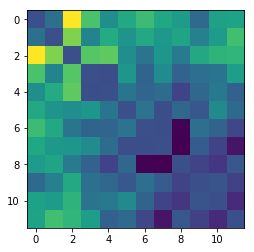

In [27]:
# Visualise speaker embedding matrix
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, pretrain_model_fn)
    np_speaker_embedding = speaker_embedding.eval()
plt.imshow(np_speaker_embedding)
speaker_distances = squareform(pdist(np_speaker_embedding, metric="euclidean"))
ordered_distances, order, link = compute_serial_matrix(speaker_distances, "ward")
np.fill_diagonal(ordered_distances, np.mean(ordered_distances))
plt.imshow(ordered_distances);

In [28]:
print("Speaker genders:")
for i in order:
    print(id_to_speaker[i], end = " ")
print()
for i in order:
    print(speaker_gender_dict[id_to_speaker[i]], end = "   ")

Speaker genders:
s06 s38 s12 s03 s13 s10 s02 s04 s08 s11 s05 s16 
m   m   f   m   m   m   f   f   f   m   f   f   

## CAE training with speaker information

In [29]:
# Training parameters
learning_rate = 0.001
n_epochs = 10 # 100
n_val_interval = 1
batch_size = 300
n_buckets = 3
pair_list = batching.get_pair_list(train_labels)

In [30]:
# Train correspondence autoencoder
np.random.seed(1)
train_batch_iterator = PairedBucketSpeakerIterator(
    train_x, train_speaker_id, pair_list, batch_size=batch_size, n_buckets=n_buckets, shuffle_every_epoch=True
    )

val_model_fn = intermediate_model_fn
record_dict = training.train_fixed_epochs_external_val(
    n_epochs, optimizer, loss, train_batch_iterator,
    [a, a_lengths, b, b_lengths, speaker_id], samediff_val, save_model_fn=intermediate_model_fn, save_best_val_model_fn=model_fn,
    n_val_interval=n_val_interval, load_model_fn=pretrain_model_fn
    )

2018-12-05 12:02:59.598150
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.ckpt
Epoch 0:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.tmp.ckpt
34.635 sec, train loss: 0.79140204, val loss: [0.34114918835351715, -0.3033072601530722] *
Epoch 1:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.tmp.ckpt
33.230 sec, train loss: 0.7237995, val loss: [0.34603992462685595, -0.30542192343018776] *
Epoch 2:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.tmp.ckpt
33.852 sec, train loss: 0.7010316, val loss: [0.34496973392215424, -0.30800594169435136] *
Epoch 3:
INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.tmp.ckpt
33.699 sec, train loss: 0.6779031, val loss: [0.3550631280597784, -0.31618502398962034] *
Epoch 4:
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.pretrain.ckpt


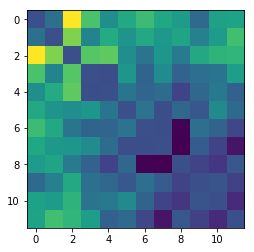

In [38]:
# Visualise speaker embedding matrix
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, pretrain_model_fn)
    np_speaker_embedding = speaker_embedding.eval()
plt.imshow(np_speaker_embedding)
speaker_distances = squareform(pdist(np_speaker_embedding, metric="euclidean"))
ordered_distances, order, link = compute_serial_matrix(speaker_distances, "ward")
np.fill_diagonal(ordered_distances, np.mean(ordered_distances))
plt.imshow(ordered_distances);

In [40]:
print("Speaker genders:")
for speaker_id in order:
    print(id_to_speaker[speaker_id], end = " ")
print()
for speaker_id in order:
    print(speaker_gender_dict[id_to_speaker[speaker_id]], end = "   ")

Speaker genders:
s06 s38 s12 s03 s13 s10 s02 s04 s08 s11 s05 s16 
m   m   f   m   m   m   f   f   f   m   f   f   

In [43]:
# Embed validation
val_batch_iterator = batching.SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z], feed_dict={a: np_x, a_lengths: np_x_lengths}
            )[0]
#         np_y = session.run(
#             [y], feed_dict={a: np_x, a_lengths: np_x_lengths, b_lengths: np_x_lengths}
#             )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/multi_lazydynamic_latent_cae_speaker.ckpt


In [44]:
# Same-different evaluation
distances = pdist(np_z, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.3162
Precision-recall breakeven: 0.3551


In [45]:
# Same-different evaluation after normalisation
np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
distances = pdist(np_z_normalised, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.3384
Precision-recall breakeven: 0.3767


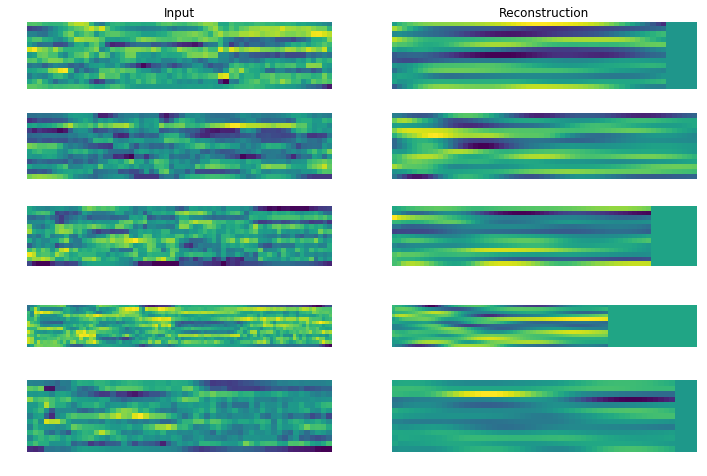

In [46]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

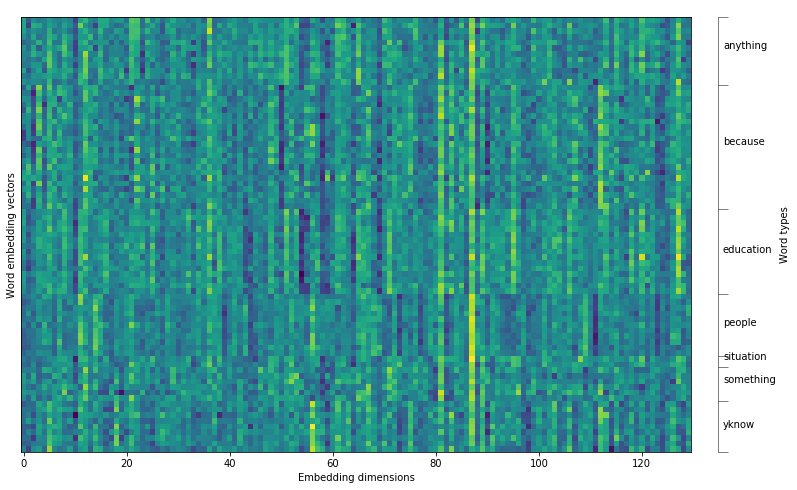

In [47]:
plotting.plot_raw_embeds(
    embed_dict, ["because", "yknow", "people", "something", "anything", "education", "situation"],
    mvn=False, figsize=(12, 8)
    )